# estimating transition marginal (K) from joint (K×K)

In [1]:
using Distributions
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
include("src/NGSIM.jl")

chmm_em! (generic function with 1 method)

In [3]:
K = 8
KK = K^2
D = 3
T = 10_000_000

model = rand_chmm(K, D)
(Z, X1, X2) = simulate_model(model, T)
;

In [4]:
W = zeros(Int, T)
for i in 1:T
    W[i] = sub2ind((K, K), Z[1, i], Z[2, i])
end

P = model.P
P_flat = empty(KK, KK)
for k in 1:KK
    i, j = ind2sub((K, K), k)
    outer!(reshape(view(P_flat, :, k), K, K), model.P[:, i, j], model.P[:, j, i])
end

## how well does it work on the data?

In [5]:
Phat_flat = zeros(KK, KK)
for i in 1:(T-1)
    Phat_flat[W[i], W[i+1]] += 1
end
Phat_flat ./= sum(Phat_flat, 1)

Phat_svd = zeros(K, K, K)
for i in 1:K
    for j in 1:i
        k1 = sub2ind((K, K), i, j)
        k2 = sub2ind((K, K), j, i)
        A = reshape(Phat_flat[:, k1], K, K) + reshape(Phat_flat[:, k2], K, K)'

        p1, p2 = estimate_outer_double(A)
        Phat_svd[:, i, j] = p1
        Phat_svd[:, j, i] = p2
    end
end

Phat_counts = zeros(K, K, K)        
for i in 1:K
    for j in 1:K
        k = sub2ind((K, K), i, j)
        A = reshape(Phat_flat[:, k], K, K)

        Phat_counts[:, i, j] .+= vec(sum(A, 2))
        Phat_counts[:, j, i] .+= vec(sum(A, 1))
    end
end
Phat_counts ./= 2
;


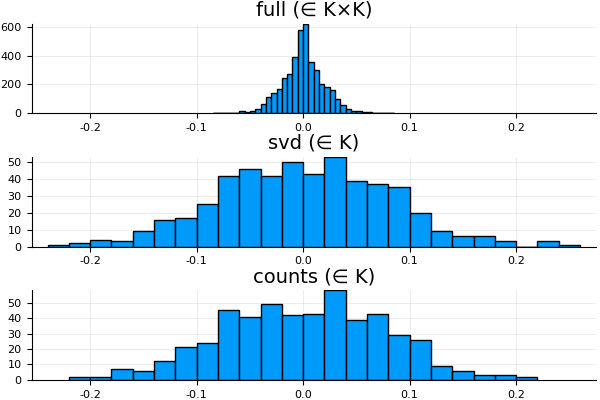

In [6]:
nbins = 30
plot(histogram(vec(Phat_flat.-P_flat), title="full (∈ K×K)", bins=nbins), 
    histogram(vec(Phat_svd.-P), title="svd (∈ K)", bins=nbins), 
    histogram(vec(Phat_counts.-P), title="counts (∈ K)", bins=nbins), 
    layout=(3, 1), link=:x, legend=false)

## how well does it work on the actual dist?

In [9]:
P_svd = zeros(K, K, K)
for i in 1:K
    for j in 1:i
        k1 = sub2ind((K, K), i, j)
        k2 = sub2ind((K, K), j, i)
        A = reshape(P_flat[:, k1], K, K) + reshape(P_flat[:, k2], K, K)'
        
        p1, p2 = estimate_outer_double(A)
        P_svd[:, i, j] = p1
        P_svd[:, j, i] = p2
    end
end

P_counts = zeros(K, K, K)        
for i in 1:K
    for j in 1:K
        k = sub2ind((K, K), i, j)
        A = reshape(P_flat[:, k], K, K)

        P_counts[:, i, j] .+= vec(sum(A, 2))
        P_counts[:, j, i] .+= vec(sum(A, 1))
    end
end
P_counts ./= 2
;


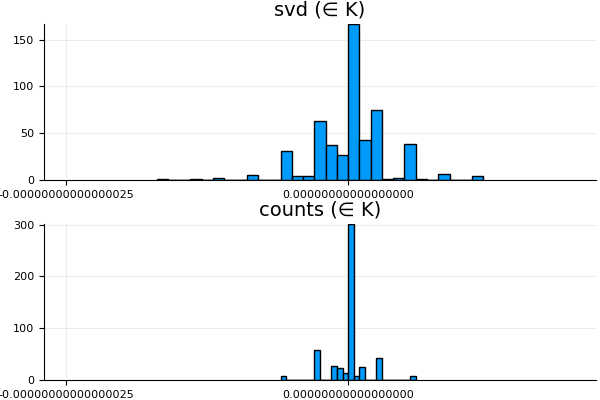

In [10]:
nbins = 30
plot(histogram(vec(P_svd.-P), title="svd (∈ K)", bins=nbins), 
    histogram(vec(P_counts.-P), title="counts (∈ K)", bins=nbins), 
    layout=(2, 1), link=:x, legend=false)